In [10]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from models.model_final import VisionTransformer, CONFIGS
from torchvision.datasets import CIFAR10

Files already downloaded and verified


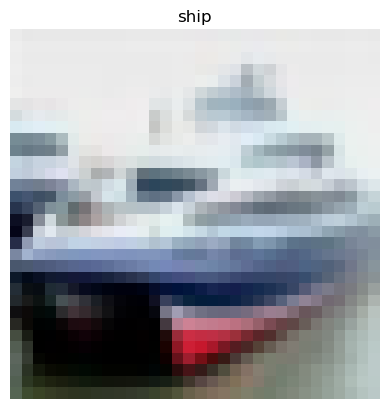

torch.Size([3, 32, 32])


In [ ]:
raw_dataset = CIFAR10(root='./data', train=False, download=True)
classes = raw_dataset.classes

transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

image_idx = 1

x = transform(raw_dataset[image_idx][0])

img = x.permute(1, 2, 0)  # 将 CHW 转换为 HWC

img = img * 0.5 + 0.5  # 逆归一化（从 [-1, 1] 到 [0, 1]）

plt.title(classes[raw_dataset[1][image_idx]])
plt.imshow(img)
plt.axis("off")
plt.show()

print(x.shape)

In [ ]:
config = CONFIGS["ViT-Ours_res0"]

model = VisionTransformer(config, num_classes=10, vis=True)
checkpoint_path = "/home/sichongjie/sichongjie-sub/ViT_torch/output_final/cifar10_No_24_checkpoint.bin" 
state_dict = torch.load(checkpoint_path, map_location="cpu")  # 加载权重文件
model.load_state_dict(state_dict)  # 加载模型参数
print(f"Loaded fine-tuned model from {checkpoint_path}")
model.eval()

Loaded fine-tuned model from /home/sichongjie/sichongjie-sub/ViT_torch/output_final/cifar10_No_24_checkpoint.bin


/tmp/ipykernel_1773141/1370932184.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location="cpu")  # 加载权重文件


VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 384, kernel_size=(4, 4), stride=(4, 4))
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0-7): 8 x Block(
          (attention_norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=384, out_features=384, bias=True)
            (fc2): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (out): Linear(in_features=384, out_features=384, bias=True)
     

torch.Size([8, 12, 65, 65])


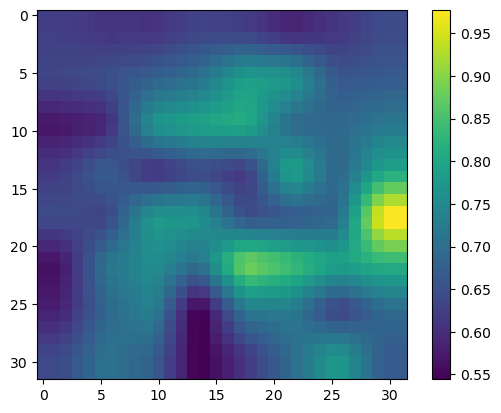

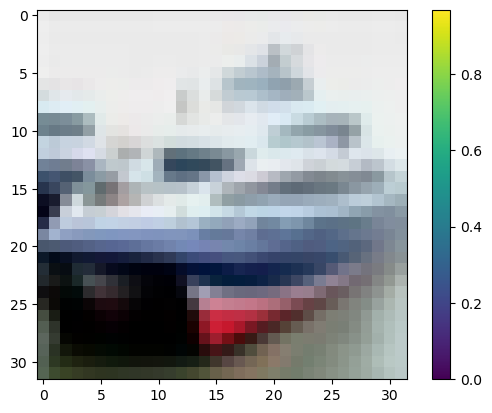

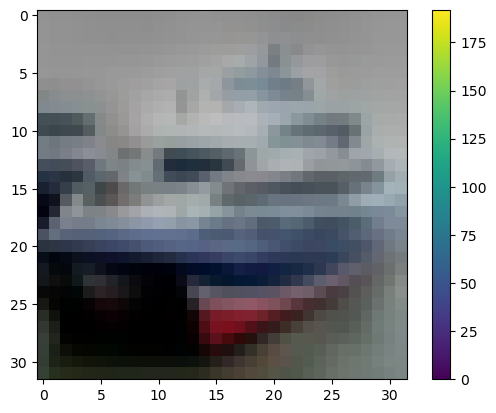

In [13]:
logits, att_mat_orig = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat_orig).squeeze(1)
print(att_mat.shape)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.

residual_att = torch.eye(att_mat.size(1))

aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)


# aug_att_mat = att_mat

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-2]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()

mask = cv2.resize(mask / mask.max(), (32, 32))[..., np.newaxis]

plt.imshow(mask.squeeze(), cmap='viridis')
plt.colorbar()
plt.show()

plt.imshow(img, cmap='viridis')
plt.colorbar()
plt.show()

img = img.detach().numpy()
result = (mask * img * 255).astype("uint8")

plt.imshow(result, cmap='viridis')
plt.colorbar()
plt.show()

In [14]:
probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label:\n")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {classes[idx.item()]}.\n', end='')

Prediction Label:

0.98863 : ship.
0.00539 : automobile.
0.00113 : dog.
0.00107 : deer.
0.00089 : bird.


### Reference
* [attention_flow](https://github.com/samiraabnar/attention_flow)
* [vit-keras](https://github.com/faustomorales/vit-keras)

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import io
from IPython.display import Image as IPImage, display

# List to store each plot as a PIL image
frames = []

for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), (img.shape[0], img.shape[1]))[..., np.newaxis]
    result = (mask * img)

    # Create the plot without axes and with tight layout
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 8))
    ax1.set_title(f'Original ({classes[raw_dataset[1][image_idx]]})')
    ax2.set_title(f'Attention Map Layer {i+1}')
    fig.subplots_adjust(wspace=0.1, hspace=0)  # Slight spacing between subplots
    ax1.imshow(img)
    ax2.imshow(result)

    # Remove axes
    ax1.axis('off')
    ax2.axis('off')
    fig.tight_layout(pad=1)  # Minimize padding around the figure   

    # Save the plot to a bytes buffer
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.2)
    plt.close(fig)
    buf.seek(0)
    
    # Convert the bytes buffer to an image and add to frames list
    frames.append(Image.open(buf))

# Save the frames as a GIF
frames[0].save(f'attention_imgs/attention_maps_{image_idx}.gif', save_all=True, append_images=frames[1:], duration=500, loop=0)

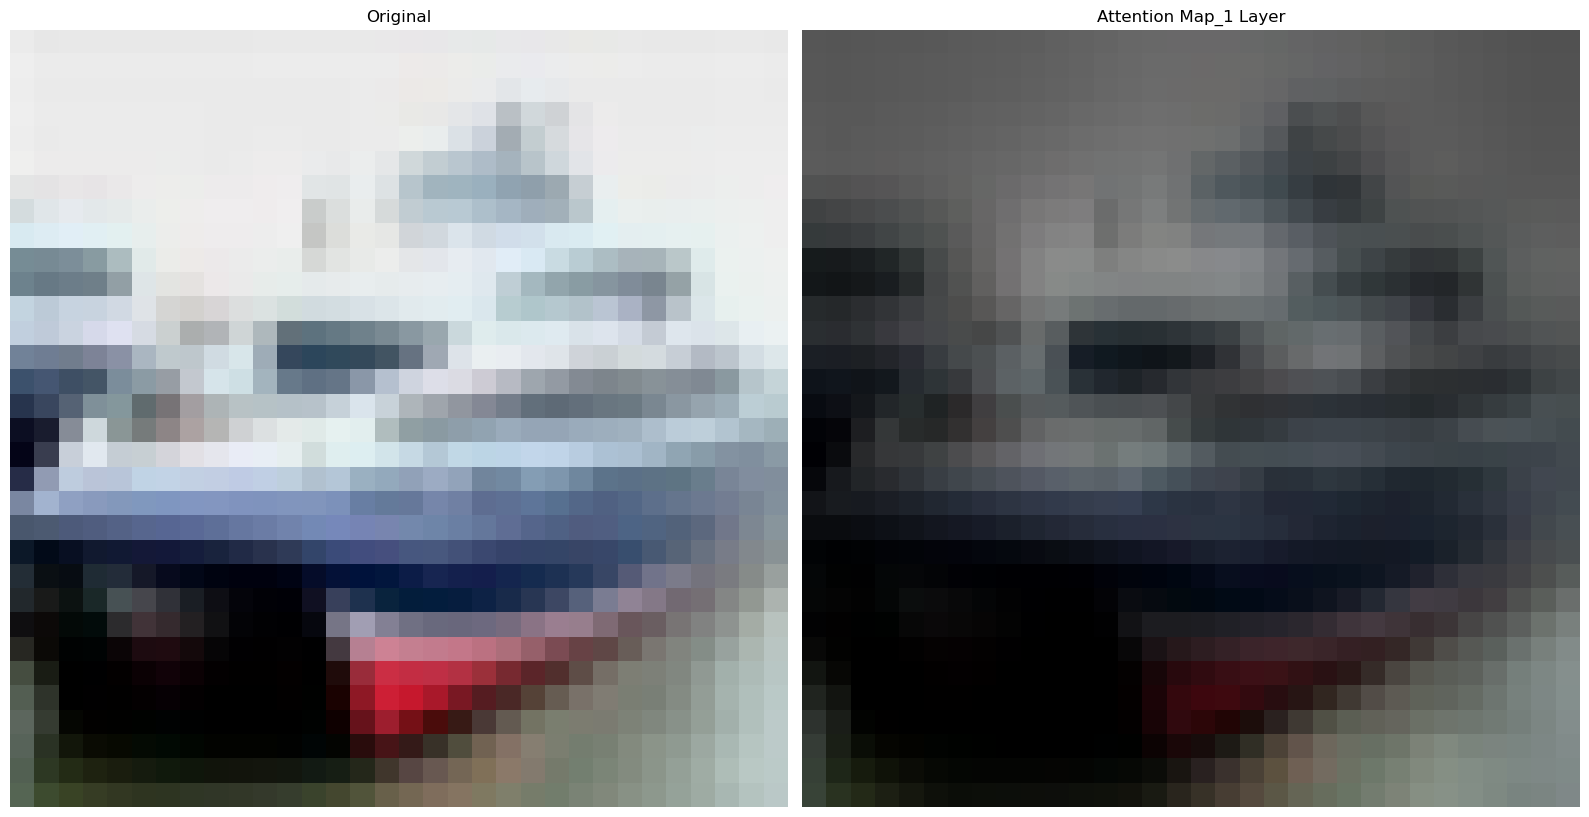

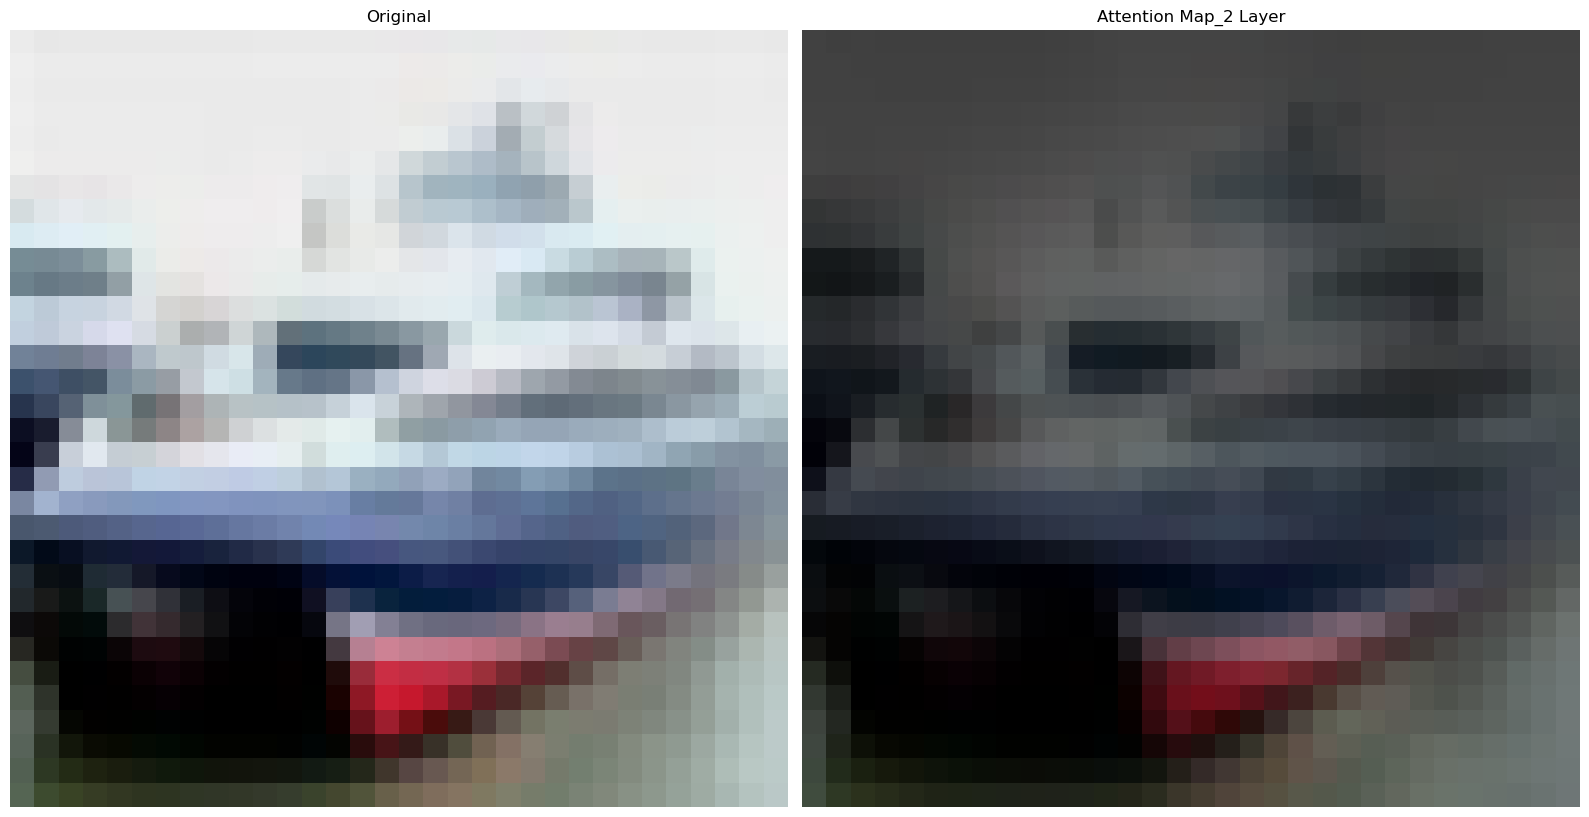

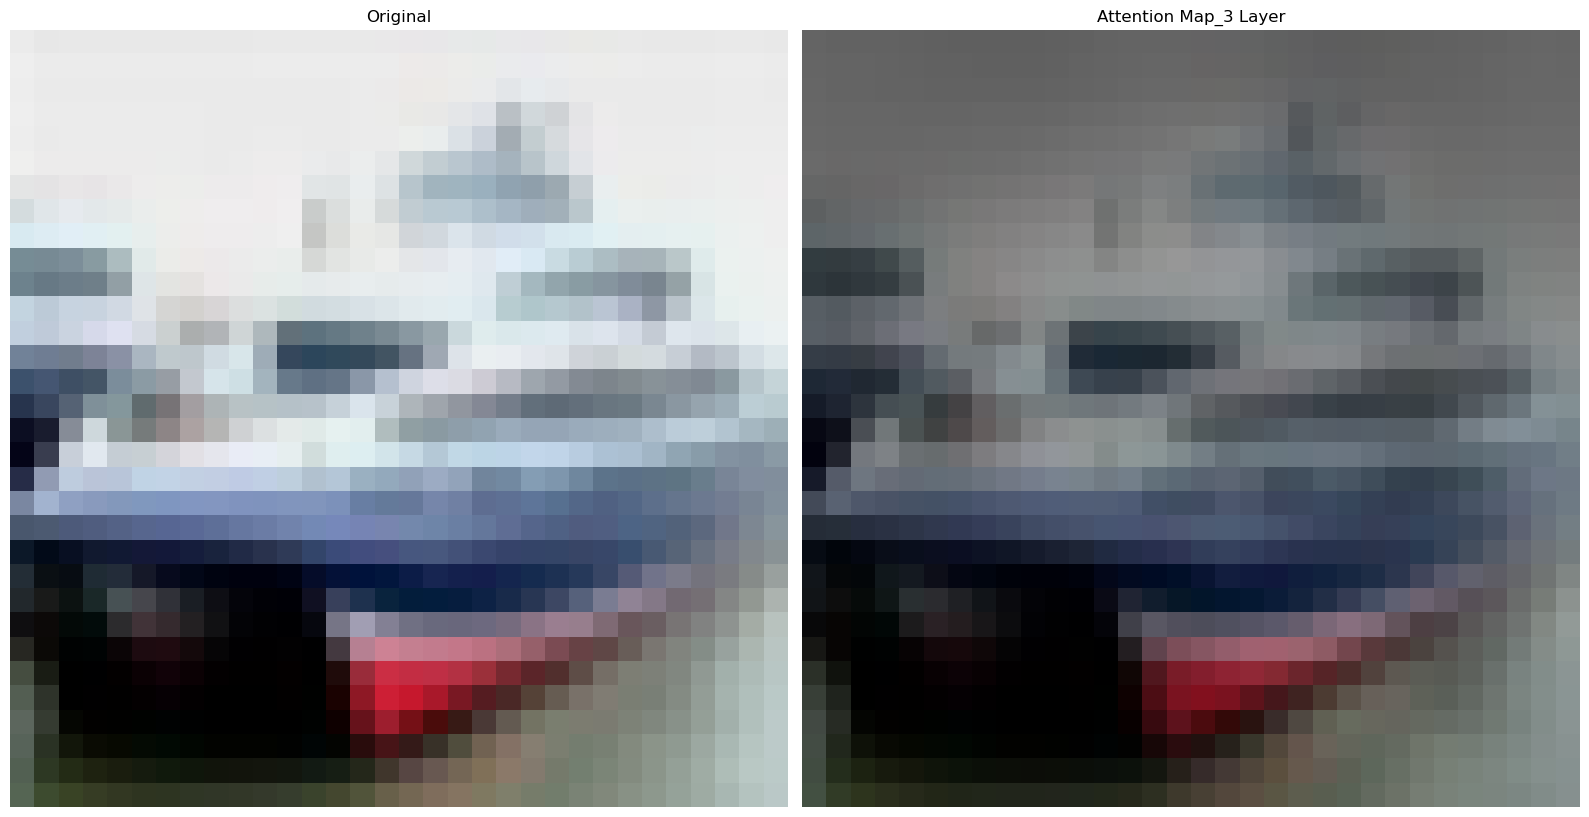

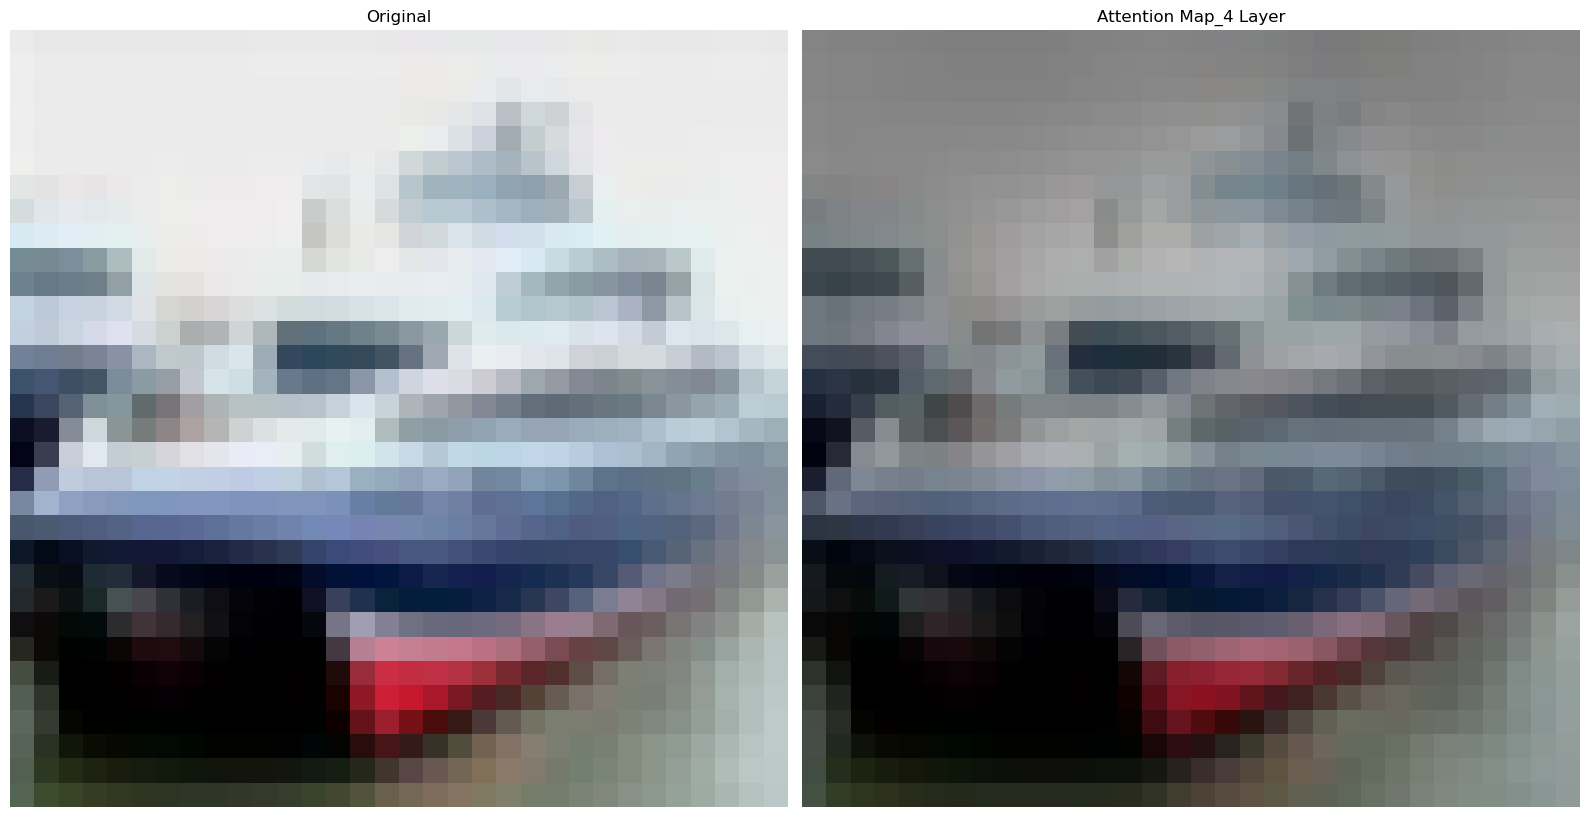

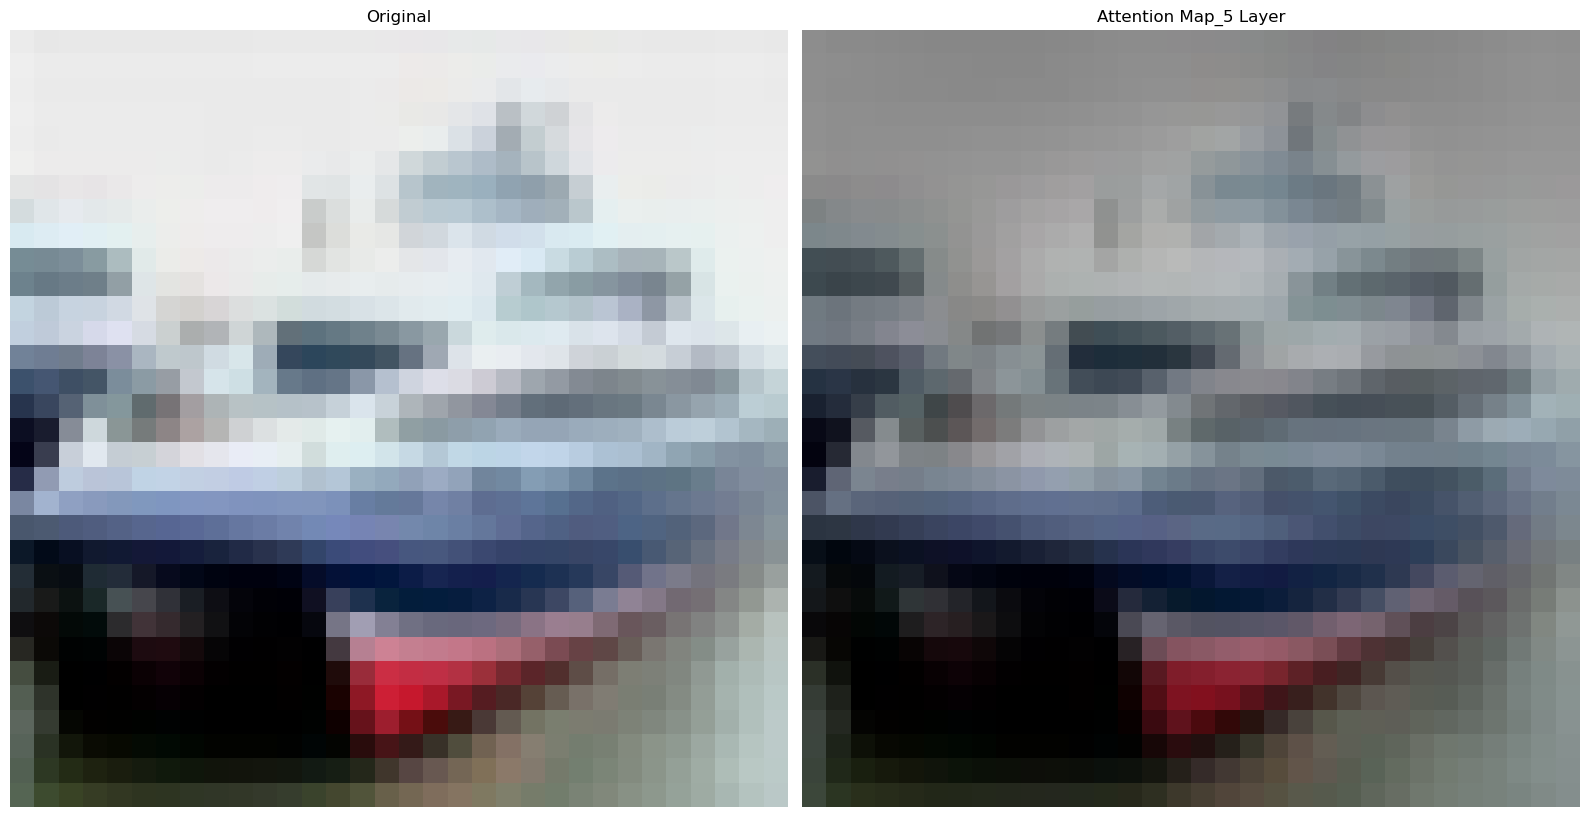

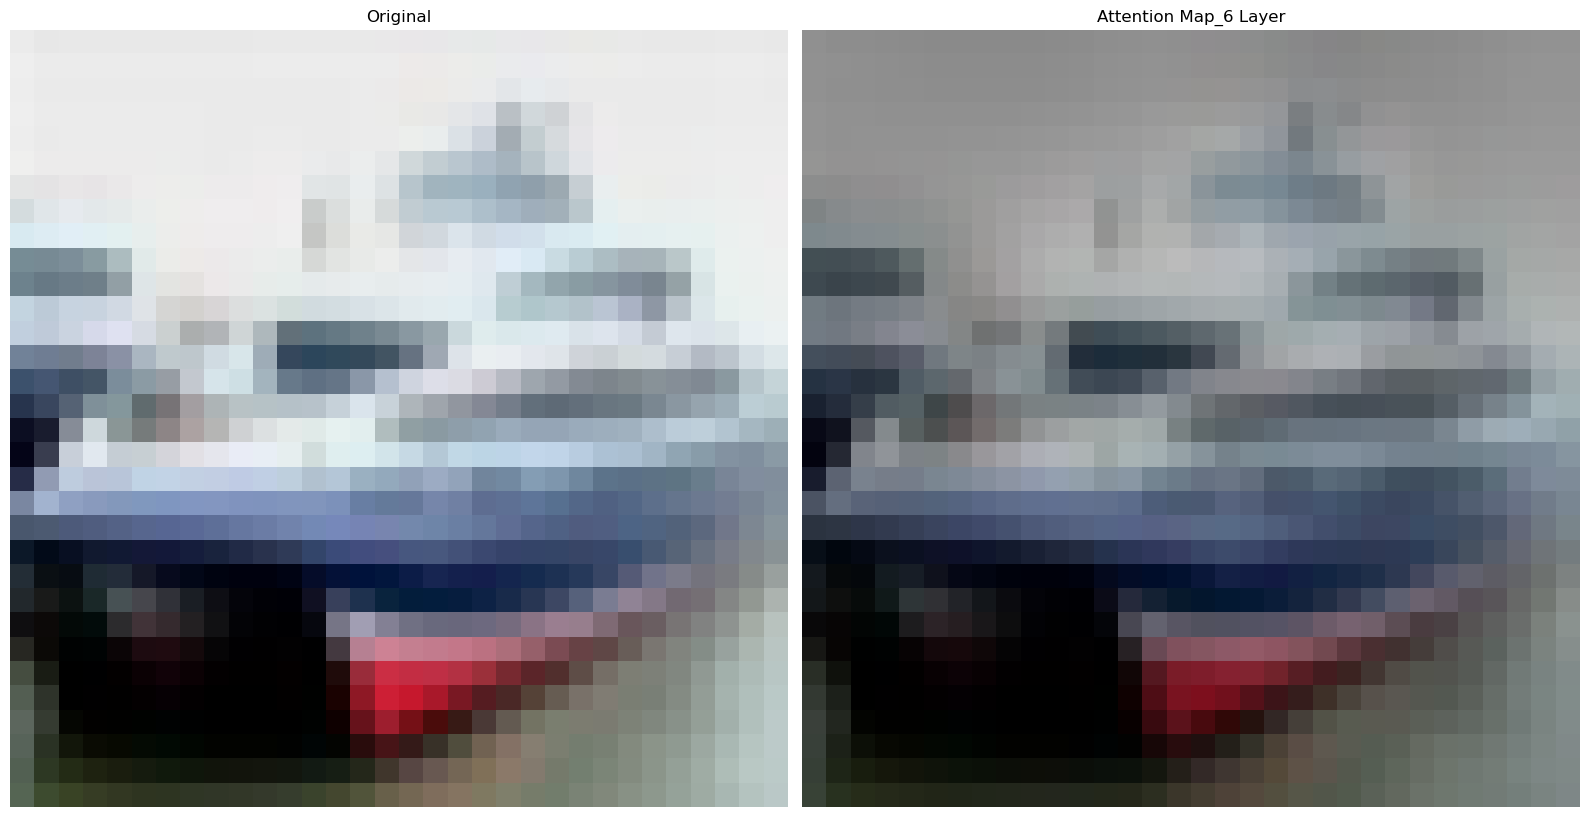

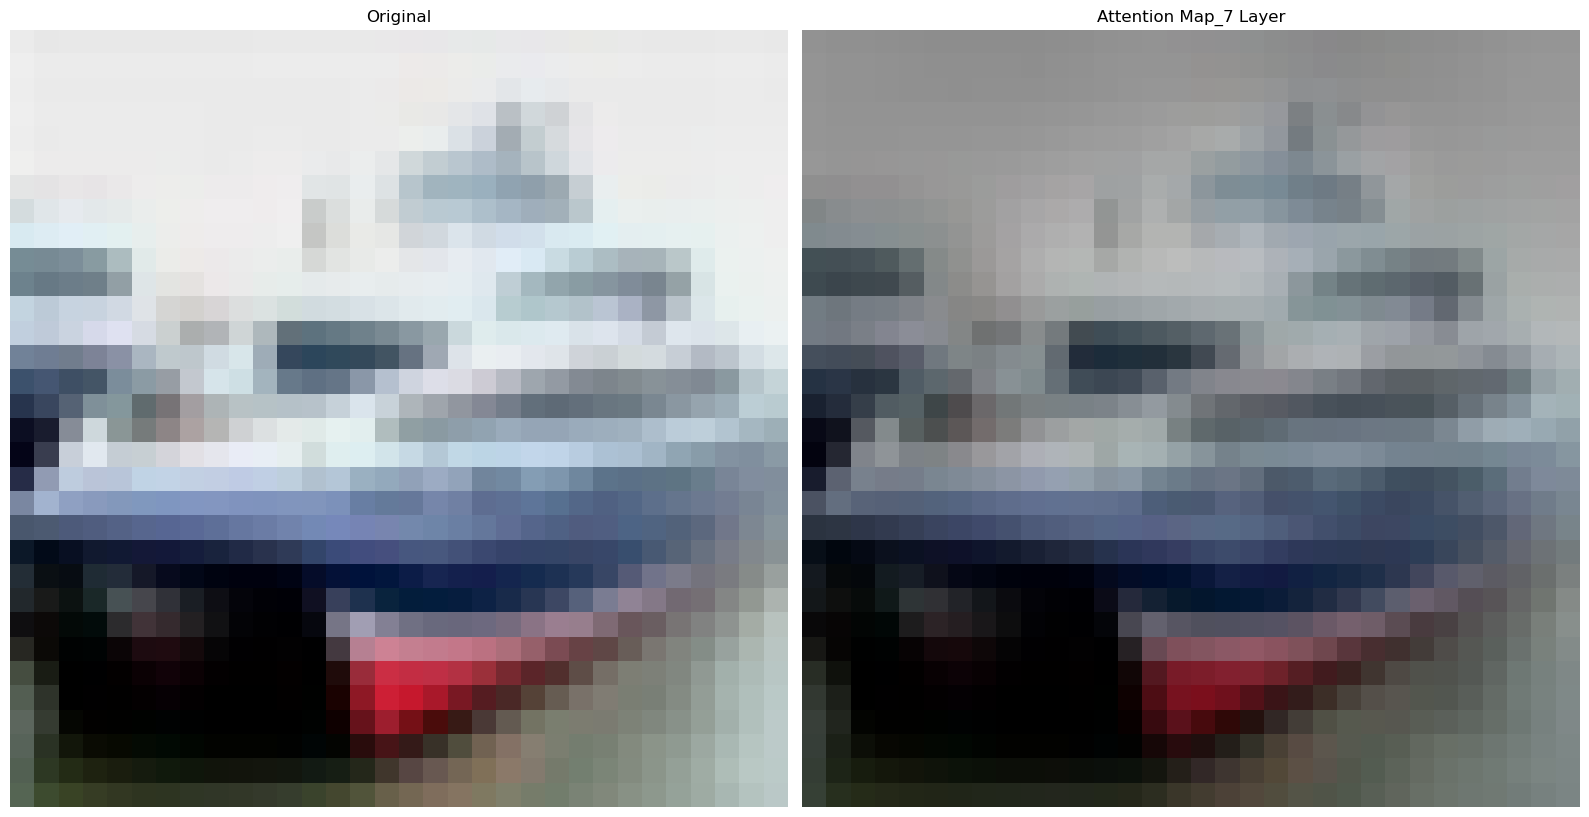

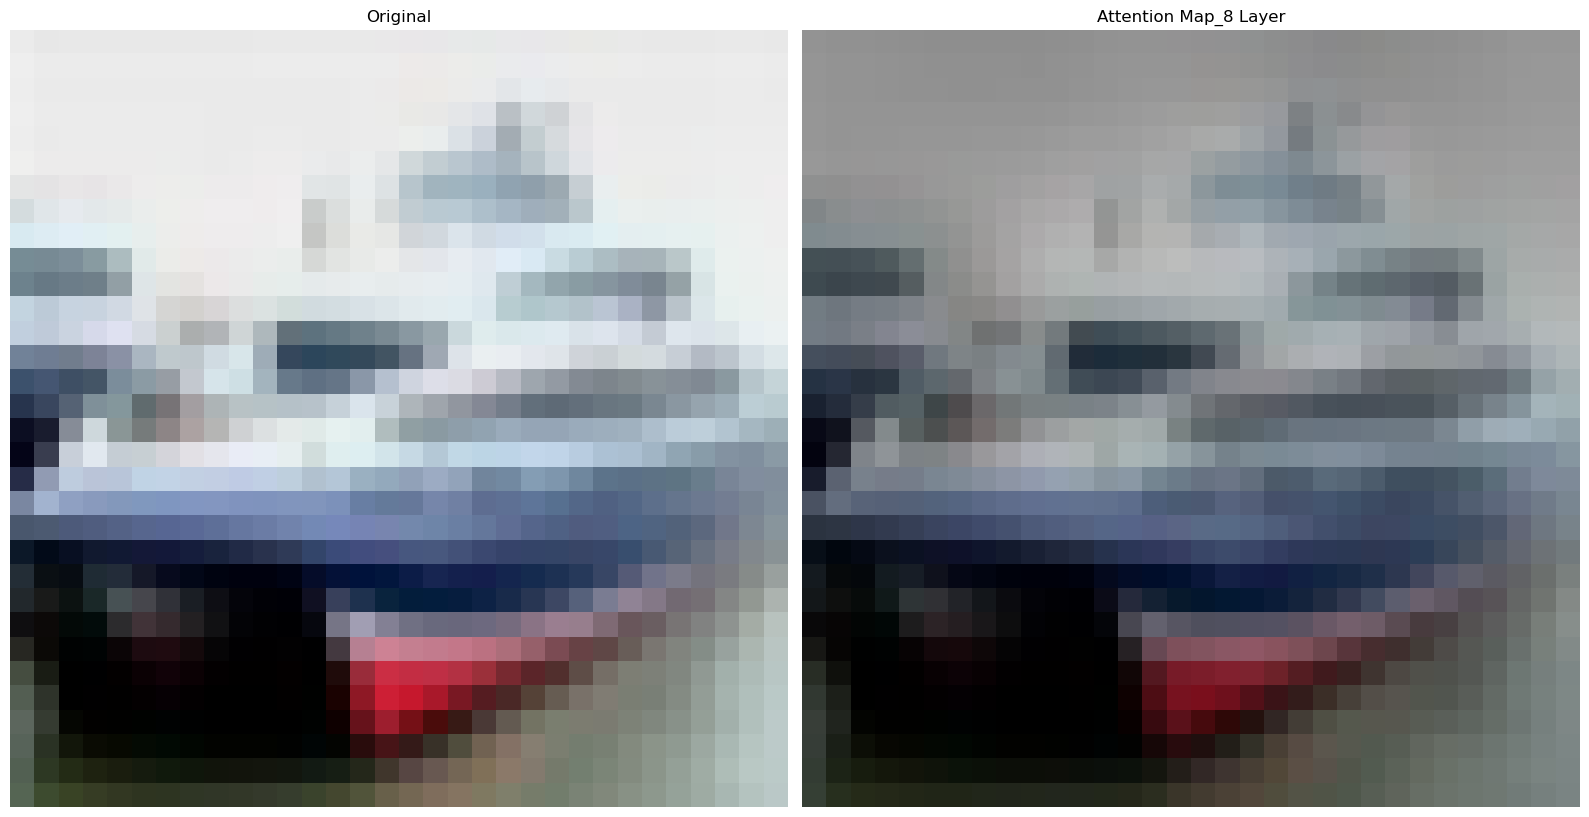

In [18]:
for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), (32, 32))[..., np.newaxis]
    result = (mask * img * 255).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax1.axis('off') 
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    ax2.axis('off') 
    fig.tight_layout()
    _ = ax1.imshow(img)
    _ = ax2.imshow(result)

